# Wavenet for time series prediction

In this tutorial, we show how to set up and train an WaveNet-based regression model with the deep4cast package. The dataset we're using is from the GEFCom2014 forecasting competition and involved hourly energy load forecasting.

In [1]:
import numpy as np

import matplotlib.pyplot as plt

from deep4cast.forecasters import Forecaster
import deep4cast.topologies as topologies

import deep4cast.custom_metrics as metrics
import pandas as pd

%matplotlib inline

# Fix random number seed for reproducibility
np.random.seed(3) 

Using TensorFlow backend.


## Data preparation

In [2]:
df = pd.read_pickle('data/GEFCom2014-E_processed.pkl')

data = df.drop(['time', 'month', 'day', 'hour'], axis=1)
data = data.dropna()

holdout = 24
data_train = data[:-holdout].copy()

load_mu = np.mean(data_train.load)
load_std = np.std(data_train.load)
temperature_mu = np.mean(data_train.temperature)
temperature_std = np.std(data_train.temperature)

data_train['load'] = (data_train['load'] - load_mu)/load_std
data_train['temperature'] = (data_train['temperature'] - temperature_mu)/temperature_std

data_train = np.expand_dims(data_train.values, 0)
data_test = np.expand_dims(np.expand_dims(df[-holdout:].load.values, 0), 2)

The time series below show hourly energy load data and hourly temperature data. We can use the temperature data as covariate for predicting the hourly load data into the future.

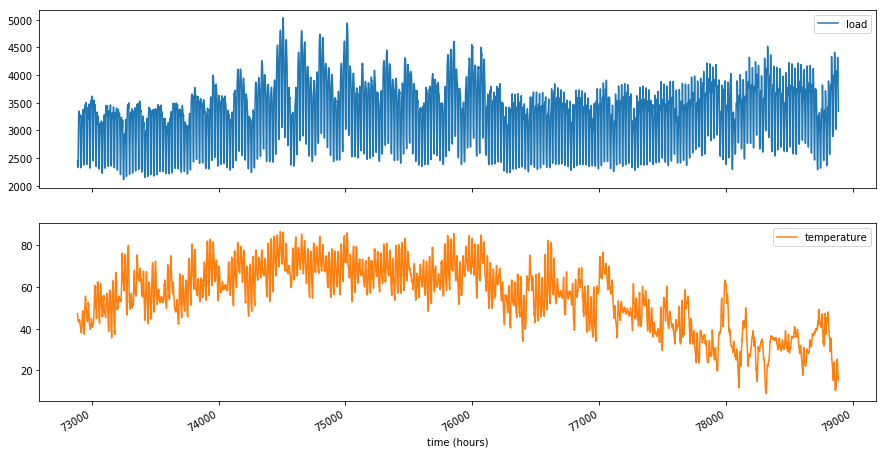

In [3]:
# Let plot the data
df[['load', 'temperature']].plot(subplots=True, figsize=(15, 8))
plt.xlabel('time (hours)')
plt.show()

# Modeling

Before we can fit a time series model, we need to specify a neural network topology that is suitable for this kind of time series. In this example, we opt for a WaveNet like topology that consists of stacked causal convolutional layers with residual connections.

In [4]:
topology = topologies.WaveNet(filters=64, num_layers=4)

In [5]:
lag = 2*holdout

forecaster = Forecaster(
    topology,
    lag=lag,  # This is the number of time steps used to predict the future for each data point
    horizon=holdout,  # This is how many time steps into the future we want to produce
    lr=0.001,  # This is the learning rate for the optimizer
    max_epochs=10
)

In [6]:
forecaster.fit(data_train, targets=[0], verbose=1)

Instructions for updating:
`NHWC` for data_format is deprecated, use `NWC` instead
Epoch 1/10
5905/5905 [==============================] - 5s 829us/step - loss: 0.7827
Epoch 2/10
5905/5905 [==============================] - 4s 729us/step - loss: -0.4129
Epoch 3/10
5905/5905 [==============================] - 4s 758us/step - loss: -0.9442
Epoch 4/10
5905/5905 [==============================] - 4s 729us/step - loss: -1.2429
Epoch 5/10
5905/5905 [==============================] - 4s 731us/step - loss: -1.4987
Epoch 6/10
5905/5905 [==============================] - 4s 740us/step - loss: -1.6888
Epoch 7/10
5905/5905 [==============================] - 4s 740us/step - loss: -1.8847
Epoch 8/10
5905/5905 [==============================] - 4s 748us/step - loss: -2.0608
Epoch 9/10
5905/5905 [==============================] - 4s 749us/step - loss: -2.1878
Epoch 10/10
5905/5905 [==============================] - 4s 745us/step - loss: -2.3547


We prevent overfitting of the model using early stopping when the validation set error stops improving. We use a patience parameters in the forecaster object to control when to stop.

Text(0,0.5,"['Loss']")

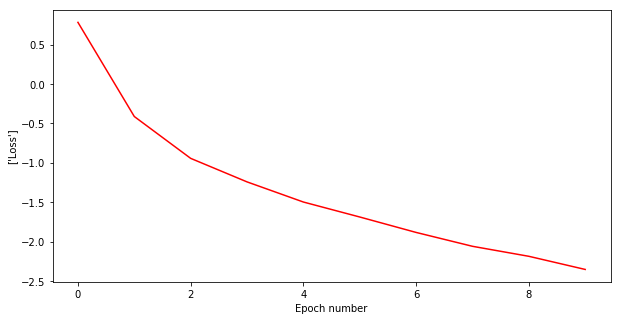

In [7]:
plt.figure(figsize=(10,5))
plt.plot(forecaster.history.epoch, forecaster.history.history['loss'], 'r')
plt.xlabel('Epoch number')
plt.ylabel(['Loss'])

# Evaluation

In [8]:
samples = forecaster.predict(data=data_train, n_samples=1000)
samples = samples.squeeze()
samples = samples*load_std + load_mu
prediction_mean = np.mean(samples, axis=0)
prediction_lq = np.percentile(samples, q=5, axis=0)
prediction_uq = np.percentile(samples, q=95, axis=0)

One meaningful way of evaluating model performance is the Mean Absolute Percentage Error (MAPE), which we use here to see how well we are doing.

SMAPE: 10.55%
Pinball Score: 51.24
Std. SMAPE: 84.2%
Coverage: 


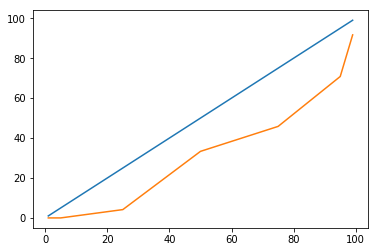

In [9]:
print('SMAPE: {}%'.format(round(metrics.smape(prediction_mean, data_test[0,:,0]), 2)))

cov, perc = metrics.coverage(samples, data_test[0,:,0])
pinball = metrics.pinball_loss(samples, data_test[0,:,0])
std_smape = metrics.std_smape(samples, data_test[0,:,0])

print('Pinball Score: {}'.format(pinball))
print('Std. SMAPE: {}%'.format(std_smape))
print('Coverage: ')
plt.plot(perc, perc)
plt.plot(perc, cov)

Lastly, we can check how our predictions compare with the data.

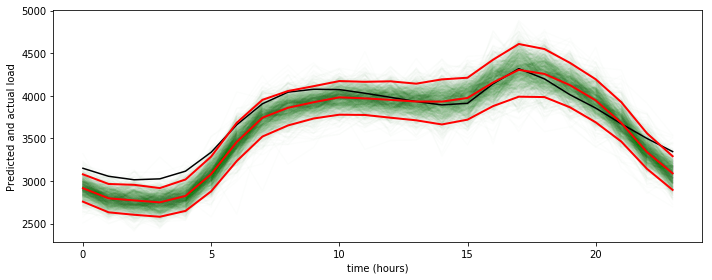

In [10]:
# We're printing the test set data and the predictions for the load data
plt.figure(figsize=(10, 4))
plt.plot(samples.T, 'g', alpha=0.01)
plt.plot(data_test[0,:,0].T, 'k')
plt.plot(prediction_mean, 'r', linewidth=2)
plt.plot(prediction_lq, 'r', linewidth=2)
plt.plot(prediction_uq, 'r', linewidth=2)
plt.xlabel('time (hours)')
plt.ylabel('Predicted and actual load')
plt.tight_layout()